In [2]:
import resource
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import idx2numpy as inp
import scipy.sparse.linalg
import scipy.spatial.distance as dist

# Loads Database

In [6]:
# also vectorises each 28 x 28 pixel image to a 784-element vector
TrImgs = np.array([img.flatten() for img in inp.convert_from_file('train-images.idx3-ubyte')])
TrLbls = inp.convert_from_file('train-labels.idx1-ubyte')
TsImgs = np.array([img.flatten() for img in inp.convert_from_file('t10k-images.idx3-ubyte')])
TsLbls = inp.convert_from_file('t10k-labels.idx1-ubyte')
# calculate TRAINING IMGS mean for use in rest of program
TrImgsMean = (np.mean(TrImgs,axis=0)).astype('int')

In [7]:
def pca(Imgs):
    """
    Principle Component Analysis: 
    1. mean-shifts all images
    2. generates list of vectors (principle components (pc)), 
    organised according to descending eigenvalues.
    
    :Params Imgs: List of images
    
    Returns:
    u: unitary matrix of pc's
    d: singular values in descending order
    """
    ImgsMean = TrImgsMean
    ImgsShifted = (Imgs-ImgsMean)
    Cov = np.cov(ImgsShifted.T)
    EVals, EVecs = np.linalg.eig(Cov)
    EValsSorted = np.flipud(np.sort(np.real(EVals))) # sorts eigenvalues in descending order
    EVecsSorted = np.real(EVecs[np.flipud(np.argsort(EVals))]) # sorts eigenvectors in the same order as EValsSorted
    return EValsSorted, EVecsSorted

In [8]:
TrD, TrU = pca(TrImgs)

In [9]:
np.save('training_set_variances',TrD)
np.save('training_set_principle_components',TrU)

In [10]:
TrD = np.load('training_set_variances.npy')
TrU = np.load('training_set_principle_components.npy')

In [26]:
def ReconstImgs(Imgs, u, p):
    """
    Reconstruct Images in Reduced Dimensions:
    1. mean-shifts all images according to TRAINING-SET MEAN 
    (not test-set mean, since all the basis vectors are defined wrt to 
    the training-set.)
    2. picks up p columns of u as a reduced basis set.
    3. reconstructs the image using this reduced basis set, 
    returns the mean shifted value.
    
    :params Imgs: Imgs.T 
    :params u: u.T gives column-organised basis set
    :params p: reduced dimension to output
    """
    ImgsMean = TrImgsMean
    ImgsShifted = (Imgs-ImgsMean)
    uCols = u.T[:p] # transpose to get columns, use the first p columns
    return (ImgsMean + (np.dot(np.dot(uCols.T,uCols),ImgsShifted.T)).T).astype('int')

## FIND THRESHOLD NUMBER OF FEATURES

include 153 features to reach 95% threshold


<IPython.core.display.Javascript object>


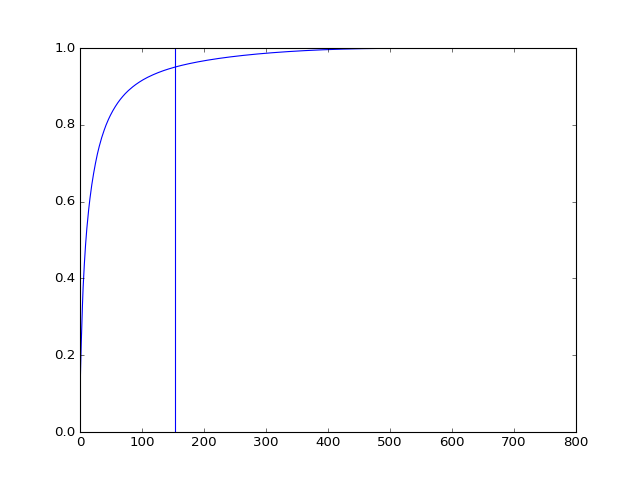

In [12]:
feature_fraction = np.cumsum(TrD)/np.sum(TrD)
threshold = np.argmin(np.abs(feature_fraction-0.95))
print 'include {} features to reach 95% threshold'.format(threshold)
plt.figure()
plt.plot(feature_fraction)
plt.axvline(threshold)

## VISUALISE RECONSTRUCTED IMAGE

<IPython.core.display.Javascript object>


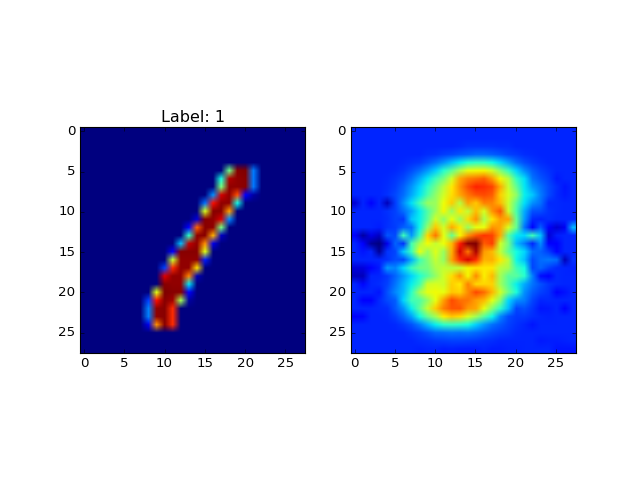

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   1
    1   1   1   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   1   2   4   5   8   8  10  10   9   8   5   3   1   1   0
    0   0   0   0   0   0   0   0   0   0   1   2   4   9  14  20  28  36
   43  47  46  40  33  23  13   7   4   1   0   0   0   0   0   0   0   0
    0   1   3   8  14  22  31  43  56  74  89  89  93  84  65  46  30  17
    9   4   2   0   0   0   0   0   0   0   1   3   7  14  24  34  45  54
   75 106 111 110 121 105  84  78  40  34   9   7   4  -5   0   0   0   0
    0   0   1   4  10  19  28  38  48  60  75  95 115 130 128 126  98  67
   46  25  15  13   6   1  -5   0   0   0   0   0   2   5  11  19  26  35
   45  57  72  90 109 123 127 119  80 

In [78]:
i = 3 #image index
p = 2 #set number of principle components
f, (ax0, ax1) = plt.subplots(1,2)
ax0.imshow(TrImgs[i].reshape(28,28)) #original
ax0.set_title('Label: '+str(TrLbls[i])) #original label
r = ReconstImgs(TrImgs[i:i+1],TrU,p) #process 10 images only for speed
print r
ax1.imshow((TrImgsMean+r[0].astype('int')).reshape(28,28))

# Projected Data

## 2 Components

In [62]:
def Comps(Imgs, u, p):
    """
    Components in Reduced Dimensions:
    1. mean-shifts all images according to TRAINING-SET MEAN 
    (not test-set mean, since all the basis vectors are defined wrt to 
    the training-set.)
    2. picks up p columns of u as a reduced basis set.
    3. returns the component sizes
    
    :params Imgs: Imgs.T 
    :params u: u.T gives column-organised basis set
    :params p: reduced dimension to output
    """
    ImgsMean = TrImgsMean
    ImgsShifted = (Imgs-ImgsMean)
    uCols = u.T[:p] # transpose to get columns, use the first p columns
    print uCols.shape
    return np.dot(uCols,ImgsShifted.T)

In [63]:
Imgs2Comps = Comps(TrImgs,TrU,2)

(2, 784)


In [66]:
Imgs2Comps[0].shape

(60000,)

<IPython.core.display.Javascript object>


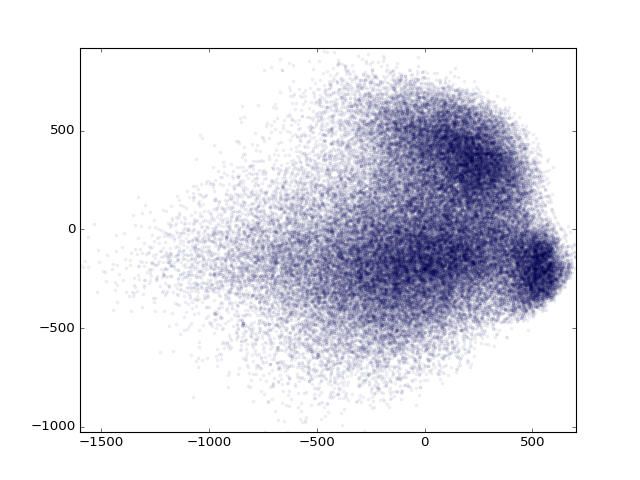

In [73]:
plt.figure()
# plt.autoscale(enable=False)
plt.scatter(Imgs2Comps[0],Imgs2Comps[1],marker='.',alpha=0.05)
plt.xlim(np.min(Imgs2Comps[0]),np.max(Imgs2Comps[0]))
plt.ylim(np.min(Imgs2Comps[1]),np.max(Imgs2Comps[1]))
plt.show()

## 3 Components

In [69]:
Imgs3Comps = Comps(TrImgs,TrU,3)

(3, 784)


<IPython.core.display.Javascript object>


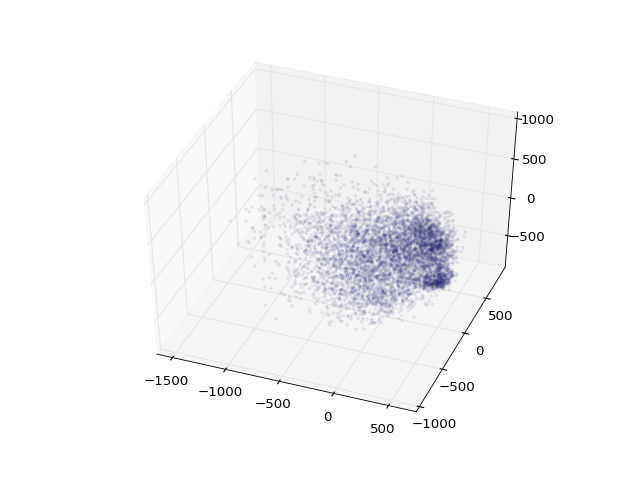

In [74]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Imgs3Comps[0][::10],Imgs3Comps[1][::10],Imgs3Comps[2][::10],marker='.',alpha=0.05)
ax.set_xlim(np.min(Imgs3Comps[0]),np.max(Imgs3Comps[0]))
ax.set_ylim(np.min(Imgs3Comps[1]),np.max(Imgs3Comps[1]))
ax.set_zlim(np.min(Imgs3Comps[2]),np.max(Imgs3Comps[2]))
plt.show()

## Visualise first 10 eigenvectors

<IPython.core.display.Javascript object>


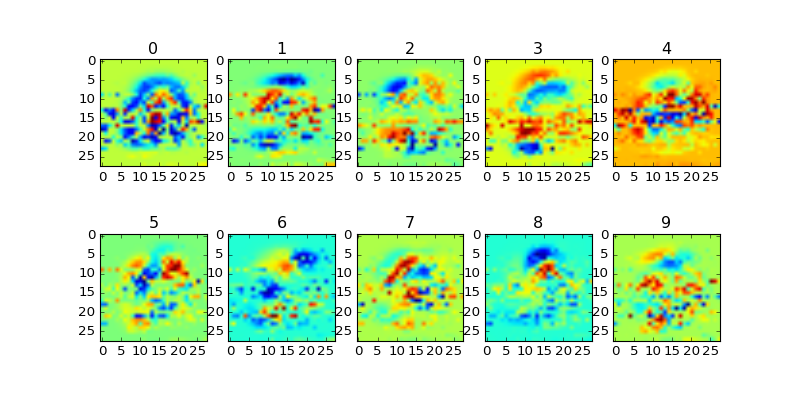

In [75]:
f, axes = plt.subplots(2,5, figsize=(10,5))
for i in range(10):
    axes[int(i/5),i%5].imshow((TrU.T[i]).reshape(28,28))
    axes[int(i/5),i%5].set_title(i)

# Generate Data of reduced dimensions and save

In [76]:
# Generate for Training Set or...
TrImgs40Comps = ReconstImgs(TrImgs,TrU,40)
TrImgs80Comps = ReconstImgs(TrImgs,TrU,80)
TrImgs200Comps = ReconstImgs(TrImgs,TrU,200)
[np.save('TrImgs{}Comps'.format(c),carr) for c, carr in zip([40,80,200],[TrImgs40Comps,TrImgs80Comps,TrImgs200Comps])]

[None, None, None]

In [4]:
# or... load
[TrImgs40Comps,TrImgs80Comps,TrImgs200Comps] = [np.load('TrImgs{}Comps.npy'.format(c)) for c in [40,80,200]]

In [77]:
# Generate for Test Set or...
TsImgs40Comps = ReconstImgs(TsImgs,TrU,40)
TsImgs80Comps = ReconstImgs(TsImgs,TrU,80)
TsImgs200Comps = ReconstImgs(TsImgs,TrU,200)
[np.save('TsImgs{}Comps'.format(c),carr) for c, carr in zip([40,80,200],[TsImgs40Comps,TsImgs80Comps,TsImgs200Comps])]

[None, None, None]

In [5]:
# or... load
[TsImgs40Comps,TsImgs80Comps,TsImgs200Comps] = [np.load('TsImgs{}Comps.npy'.format(c)) for c in [40,80,200]]

## Visualise reconstructed TEST data

<IPython.core.display.Javascript object>


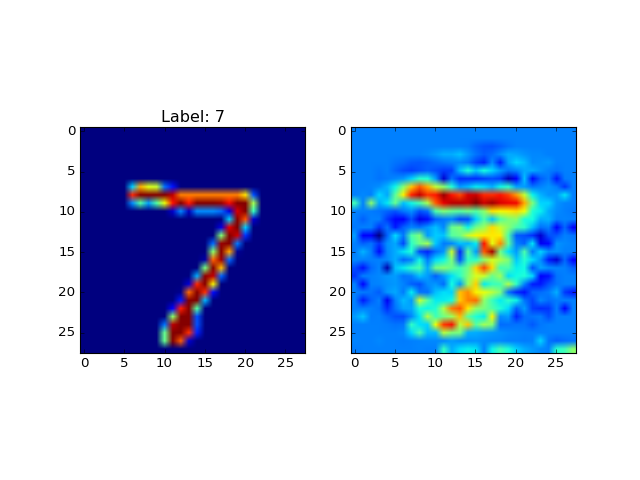

In [82]:
i = 0 #image index
p = 100 #set number of principle components
f, (ax0, ax1) = plt.subplots(1,2)
ax0.imshow(TsImgs[i].reshape(28,28)) #original
ax0.set_title('Label: '+str(TsLbls[i])) #original label
r = ReconstImgs(TsImgs[i:i+1],TrU,p) #process 10 images only for speed
ax1.imshow((r[i]).reshape(28,28))

In [87]:
TsImgs40Comps[1].dtype

dtype('int64')

In [86]:
# Generate euclidean-distance matrices
# cdist(XA,XB) returns metric dist(u=XA[i], v=XB[j]) ij-th entry.
d40 = dist.cdist(TsImgs40Comps,TrImgs40Comps)
np.save('distances_between_test_and_training_set_40_comps',d40)

In [ ]:
d80 = dist.cdist(TsImgs80Comps-TrImgsMean,TrImgs80Comps-TrImgsMean)
np.save('distances_between_test_and_training_set_80_comps',d80)

In [89]:
d40[0]

array([ 1511.70731294,  1594.85798741,  1316.23706072, ...,  1348.52067096,
        1492.24227255,  1264.80275142])

In [ ]:
[np.save('distances_between_test_and_training_set_{}_comps'.format(c),carr) for c, carr in zip([40,80,200],[d40,d80,d200])]

In [ ]:
# def KCl(x,k,TrImgs):
#     """
#     K-Nearest neighbours classifier
#     1. 
#     """